# Implementación de Transformers para Procesamiento de Lenguaje Natural (NLP)


### Objetivo
En esta evaluación, implementaremos un modelo basado en arquitecturas de Transformers para una tarea de procesamiento de lenguaje natural (NLP), utilizando el dataset **DailyDialog**. Este conjunto de datos de diálogos permite que el modelo practique en generación de texto y comprensión de contexto en interacciones cotidianas.

Usaremos TensorFlow para construir un modelo transformer básico con las siguientes características:
- **Encoder-Decoder**: para procesar la entrada y generar salida secuencial.
- **Atención Multi-cabezal**: para capturar dependencias a largo plazo en el diálogo.

Al final, evaluaremos el modelo utilizando métricas específicas de NLP, como BLEU o ROUGE.


## 1. Carga y Exploración del Dataset: DailyDialog

In [ ]:
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/train.csv
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/test.csv
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/validation.csv

--2025-06-26 23:33:15--  https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6233555 (5.9M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   5.94M  --.-KB/s    in 0.08s   

2025-06-26 23:33:15 (78.8 MB/s) - ‘train.csv’ saved [6233555/6233555]

--2025-06-26 23:33:15--  https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561656 (548

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ast
import re
import unicodedata
import keras_nlp
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from keras_nlp.tokenizers import BytePairTokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import sent_tokenize  # Más robusto que split simple
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
print(keras_nlp.__version__)

0.18.1


In [ ]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=92314bbea4310a86422e8f94bbd45e59151028ac51989b97a5e159bd40171e34
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# Si quieres usar ROUGE, instala primero: pip install rouge-score
try:
    from rouge_score import rouge_scorer
    rouge_available = True
except ImportError:
    rouge_available = False

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
validation = pd.read_csv('validation.csv')

In [ ]:
train

,dialog,act,emotion
0,"['Say , Jim , how about going for a few beers ...",[3 4 2 2 2 3 4 1 3 4],[0 0 0 0 0 0 4 4 4 4]
1,"['Can you do push-ups ? '\n "" Of course I can ...",[2 1 2 2 1 1],[0 0 6 0 0 0]
2,"['Can you study with the radio on ? '\n ' No ,...",[2 1 2 1 1],[0 0 0 0 0]
3,['Are you all right ? '\n ' I will be all righ...,[2 1 1 1],[0 0 0 0]
4,"['Hey John , nice skates . Are they new ? '\n ...",[2 1 2 1 1 2 1 3 4],[0 0 0 0 0 6 0 6 0]
...,...,...,...
11113,"['Hello , I bought a pen in your shop just bef...",[1 1 1 2 3 2 1 4 1],[0 4 0 0 0 0 0 0 4]
11114,['Do you have any seats available ? ' ' Yes . ...,[2 1 2 1 3 4],[0 0 0 0 0 4]
11115,"['Uncle Ben , how did the Forbidden City get t...",[2 1 2 1 1 1 1 1 2 1 2 1 2 1 3 4],[0 0 6 0 6 0 0 0 0 0 0 0 0 0 4 0]
11116,"['May I help you , sir ? ' ' I want a pair of ...",[2 3 4 3],[0 0 0 0]


In [ ]:
train['dialog'][0]

'[\'Say , Jim , how about going for a few beers after dinner ? \'\n \' You know that is tempting but is really not good for our fitness . \'\n \' What do you mean ? It will help us to relax . \'\n " Do you really think so ? I don\'t . It will just make us fat and act silly . Remember last time ? "\n " I guess you are right.But what shall we do ? I don\'t feel like sitting at home . "\n \' I suggest a walk over to the gym where we can play singsong and meet some of our friends . \'\n " That\'s a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . "\n \' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . \'\n " Good.Let \' s go now . " \' All right . \']'

### 1. Normalización

In [ ]:
def normalize_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'([.,;?!])', r' \1 ', text)
    text = re.sub(r'[^a-zA-Z0-9áéíóúñÁÉÍÓÚÑ .,;?!]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

#### Train

In [ ]:
texto_norm_train = [normalize_text(a) for a in train['dialog']]

In [ ]:
texto_norm_train[0]

'say , jim , how about going for a few beers after dinner ? you know that is tempting but is really not good for our fitness . what do you mean ? it will help us to relax . do you really think so ? i dont . it will just make us fat and act silly . remember last time ? i guess you are right . but what shall we do ? i dont feel like sitting at home . i suggest a walk over to the gym where we can play singsong and meet some of our friends . thats a good idea . i hear mary and sally often go there to play pingpong . perhaps we can make a foursome with them . sounds great to me ! if they are willing , we could ask them to go dancing with us . that is excellent exercise and fun , too . good . let s go now . all right .'

In [ ]:
texto_norm_train

['say , jim , how about going for a few beers after dinner ? you know that is tempting but is really not good for our fitness . what do you mean ? it will help us to relax . do you really think so ? i dont . it will just make us fat and act silly . remember last time ? i guess you are right . but what shall we do ? i dont feel like sitting at home . i suggest a walk over to the gym where we can play singsong and meet some of our friends . thats a good idea . i hear mary and sally often go there to play pingpong . perhaps we can make a foursome with them . sounds great to me ! if they are willing , we could ask them to go dancing with us . that is excellent exercise and fun , too . good . let s go now . all right .',
 'can you do pushups ? of course i can . its a piece of cake ! believe it or not , i can do 30 pushups a minute . really ? i think thats impossible ! you mean 30 pushups ? yeah ! its easy . if you do exercise everyday , you can make it , too .',
 'can you study with the rad

#### Validación

In [ ]:
texto_norm_val = [normalize_text(a) for a in validation['dialog']]

In [ ]:
texto_norm_val[0]

'good morning , sir . is there a bank near here ? there is one . 5 blocks away from here ? well , thats too far . can you change some money for me ? surely , of course . what kind of currency have you got ? rib . how much would you like to change ? 1000 yuan . here you are .'

#### Test

In [ ]:
texto_norm_test = [normalize_text(a) for a in test['dialog']]

In [ ]:
texto_norm_test[0]

'hey man , you wanna buy some weed ? some what ? weed ! you know ? pot , ganja , mary jane some chronic ! oh , umm , no thanks . i also have blow if you prefer to do a few lines . no , i am ok , really . come on man ! i even got dope and acid ! try some ! do you really have all of these drugs ? where do you get them from ? i got my connections ! just tell me what you want and i ll even give you one ounce for free . sounds good ! let s see , i want . yeah ? i want you to put your hands behind your head ! you are under arrest !'

### Agrupar en pares

In [ ]:
def dialog_to_pairs(dialogs):
    inputs = []
    targets = []
    for dialog in dialogs:
        turns = [t.strip() for t in dialog.split('\n') if t.strip()]
        for i in range(len(turns) - 1):
            inputs.append(turns[i])
            targets.append(turns[i + 1])
    return inputs, targets

# Usa la columna original, no la normalizada
train_inputs_text, train_targets_text = dialog_to_pairs(train['dialog'])
val_inputs_text, val_targets_text = dialog_to_pairs(validation['dialog'])
test_inputs_text, test_targets_text = dialog_to_pairs(test['dialog'])

# Normaliza después de separar en pares
train_inputs_text = [normalize_text(t) for t in train_inputs_text]
train_targets_text = [normalize_text(t) for t in train_targets_text]
val_inputs_text = [normalize_text(t) for t in val_inputs_text]
val_targets_text = [normalize_text(t) for t in val_targets_text]
test_inputs_text = [normalize_text(t) for t in test_inputs_text]
test_targets_text = [normalize_text(t) for t in test_targets_text]

print(len(train_inputs_text), len(train_targets_text))
print(train_inputs_text[:3])
print(train_targets_text[:3])

64998 64998
['say , jim , how about going for a few beers after dinner ?', 'you know that is tempting but is really not good for our fitness .', 'what do you mean ? it will help us to relax .']
['you know that is tempting but is really not good for our fitness .', 'what do you mean ? it will help us to relax .', 'do you really think so ? i dont . it will just make us fat and act silly . remember last time ?']


### Tokenización

In [ ]:
vectorizer = TextVectorization(
    max_tokens=8000,
    output_sequence_length=128,
    standardize=None  # Ya hicimos la normalización
)

In [ ]:
vectorizer.adapt(train_inputs_text + train_targets_text)

In [ ]:
print(len(train_inputs_text), len(train_targets_text))
print(train_inputs_text[:3])
print(train_targets_text[:3])

64998 64998
['say , jim , how about going for a few beers after dinner ?', 'you know that is tempting but is really not good for our fitness .', 'what do you mean ? it will help us to relax .']
['you know that is tempting but is really not good for our fitness .', 'what do you mean ? it will help us to relax .', 'do you really think so ? i dont . it will just make us fat and act silly . remember last time ?']


In [ ]:
train_inputs = vectorizer(train_inputs_text).numpy()
train_targets = vectorizer(train_targets_text).numpy()
val_inputs = vectorizer(val_inputs_text).numpy()
val_targets = vectorizer(val_targets_text).numpy()

In [ ]:
test_inputs = vectorizer(test_inputs_text).numpy()
test_targets = vectorizer(test_targets_text).numpy()

In [ ]:
# 5. Ejemplo de tokenización
ejemplo = "habia una vez un señor llamado pedro y se fue corriendo"
encoded = vectorizer([ejemplo])
print(f"Texto original: {ejemplo}")
print(f"IDs tokenizados: {encoded.numpy()}")

Texto original: habia una vez un señor llamado pedro y se fue corriendo
IDs tokenizados: [[   1    1    1    1    1    1    1 6035    1    1    1    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


### Attention masks

In [ ]:
##### EN ESTE PASO DA ERROR POR SUPERAR LA MEMORIA DE LA GPU #####

# def create_padding_mask(inputs):
#     return tf.cast(inputs != 0, tf.float32)  # 0 es el ID del padding en TextVectorization

# def create_look_ahead_mask(seq_len):
#     return 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

# # Padding masks
# train_padding_mask = create_padding_mask(train_inputs)
# val_padding_mask = create_padding_mask(val_inputs)

# # Look-ahead (estático si tienes secuencia fija)
# seq_len = train_inputs.shape[1]
# look_ahead_mask = create_look_ahead_mask(seq_len)
# look_ahead_mask = tf.expand_dims(look_ahead_mask, axis=0)  # shape (1, L, L)
# look_ahead_mask = tf.repeat(look_ahead_mask, repeats=train_inputs.shape[0], axis=0)

### Padding

In [ ]:
padded_train_inputs = pad_sequences(train_inputs, padding='post', maxlen=128)
padded_train_targets = pad_sequences(train_targets, padding='post', maxlen=128)
padded_val_inputs = pad_sequences(val_inputs, padding='post', maxlen=128)
padded_val_targets = pad_sequences(val_targets, padding='post', maxlen=128)

## 2. Implementación del Modelo Transformer

In [ ]:
# def positional_encoding(seq_len, d_model):
#     pos = np.arange(seq_len)[:, np.newaxis]
#     i = np.arange(d_model)[np.newaxis, :]
#     angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
#     angle_rads = pos * angle_rates

#     # aplicar sin en indices pares, cos en impares
#     pos_encoding = np.zeros(angle_rads.shape)
#     pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
#     pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

#     pos_encoding = pos_encoding[np.newaxis, ...]
#     return tf.cast(pos_encoding, dtype=tf.float32)

### Encoder

In [ ]:
def transformer_encoder(embed_dim, num_heads, ff_dim):
    inputs = tf.keras.Input(shape=(None, embed_dim))
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention = tf.keras.layers.Dropout(0.4)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + inputs)
    ffn = tf.keras.layers.Dense(ff_dim, activation='relu')(attention)
    ffn = tf.keras.layers.Dense(embed_dim)(ffn)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ffn + attention)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


### Decoder

In [ ]:
def transformer_decoder(embed_dim, num_heads, ff_dim, dropout=0.1):
    target_seq = tf.keras.Input(shape=(None, embed_dim), name="target_seq")
    enc_output = tf.keras.Input(shape=(None, embed_dim), name="enc_output")
    attn1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(
        target_seq, target_seq, use_causal_mask=True)
    attn1 = tf.keras.layers.Dropout(dropout)(attn1)
    out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn1 + target_seq)
    attn2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(
        out1, enc_output)
    attn2 = tf.keras.layers.Dropout(dropout)(attn2)
    out2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn2 + out1)
    ff = tf.keras.layers.Dense(ff_dim, activation='relu')(out2)
    ff = tf.keras.layers.Dense(embed_dim)(ff)
    out3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff + out2)
    return tf.keras.Model(inputs=[target_seq, enc_output], outputs=out3)

In [ ]:
def create_decoder_io(sequences, bos_token_id=1, seq_len=128):
    decoder_inputs = []
    decoder_targets = []
    for seq in sequences:
        seq = list(seq)
        # recorta o rellena a seq_len-1
        seq = seq[:seq_len-1] + [0]*(seq_len-1-len(seq))
        dec_in = [bos_token_id] + seq  # [BOS] + seq[:-1]
        dec_in = dec_in[:seq_len]
        dec_tgt = seq + [0]            # seq + [PAD]
        dec_tgt = dec_tgt[:seq_len]
        decoder_inputs.append(dec_in)
        decoder_targets.append(dec_tgt)
    return np.array(decoder_inputs), np.array(decoder_targets)

In [ ]:
# Parámetros
vocab_size = 8000
embed_dim = 128
num_heads = 8
ff_dim = 512
sequence_length = 128

# Embedding compartido
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)

# Inputs
encoder_inputs = tf.keras.Input(shape=(sequence_length,), name="encoder_inputs")
decoder_inputs = tf.keras.Input(shape=(sequence_length,), name="decoder_inputs")

# Embedding
enc_emb = embedding_layer(encoder_inputs)
dec_emb = embedding_layer(decoder_inputs)

# Encoder y Decoder
encoder = transformer_encoder(embed_dim, num_heads, ff_dim)
decoder = transformer_decoder(embed_dim, num_heads, ff_dim)

enc_out = encoder(enc_emb)
dec_out = decoder([dec_emb, enc_out])

# Output final
outputs = tf.keras.layers.Dense(vocab_size)(dec_out)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_1' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
# Modelo completo
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
decoder_inputs_train, decoder_targets_train = create_decoder_io(train_targets, seq_len=128)
decoder_inputs_val, decoder_targets_val = create_decoder_io(val_targets, seq_len=128)

In [ ]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'encoder_inputs': train_inputs,
        'decoder_inputs': decoder_inputs_train
    },
    decoder_targets_train
)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'encoder_inputs': val_inputs,
        'decoder_inputs': decoder_inputs_val
    },
    decoder_targets_val
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## 3. Entrenamiento del Modelo

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 109s 46ms/step - accuracy: 0.8913 - loss: 0.9837 - val_accuracy: 0.9061 - val_loss: 0.5177
Epoch 2/10
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - accuracy: 0.9029 - loss: 0.5331 - val_accuracy: 0.9080 - val_loss: 0.4929
Epoch 3/10
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 88s 44ms/step - accuracy: 0.9054 - loss: 0.4978 - val_accuracy: 0.9091 - val_loss: 0.4817
Epoch 4/10
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 140s 43ms/step - accuracy: 0.9072 - loss: 0.4729 - val_accuracy: 0.9098 - val_loss: 0.4769
Epoch 5/10
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 142s 43ms/step - accuracy: 0.9090 - loss: 0.4528 - val_accuracy: 0.9102 - val_loss: 0.4757
Epoch 6/10
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 89s 44ms/step - accuracy: 0.9107 - loss: 0.4356 - val_accuracy: 0.9103 - val_loss: 0.4755
Epoch 7/10
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 140s 43ms/step - accuracy: 0.9124 - loss: 0.4213 - val_accuracy: 0.9108 - val_loss: 0.4769
Epoch 8/10
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 89s 44ms/step - accuracy: 0.91

In [ ]:
def decode_sequence(input_text, model, vectorizer, max_len_target=82, bos_token=1, eos_token=2, seq_len=128):
    # Tokeniza la pregunta
    input_ids = vectorizer([input_text]).numpy()[0]
    encoder_input = tf.expand_dims(input_ids, 0)  # (1, seq_len)
    decoder_input = [bos_token]
    for _ in range(max_len_target):
        # Pad decoder_input a longitud seq_len
        dec_input_padded = decoder_input + [0] * (seq_len - len(decoder_input))
        dec_input_tensor = tf.expand_dims(dec_input_padded, 0)  # (1, seq_len)
        predictions = model([encoder_input, dec_input_tensor])
        predicted_id = tf.argmax(predictions[0, len(decoder_input)-1]).numpy()
        if predicted_id == eos_token or len(decoder_input) >= seq_len:
            break
        decoder_input.append(predicted_id)
    # Decodifica tokens a texto
    vocab = vectorizer.get_vocabulary()
    respuesta = " ".join([vocab[tok] for tok in decoder_input[1:] if tok < len(vocab) and tok != 0])
    return respuesta

In [ ]:
response = decode_sequence("how are you?", model, vectorizer, max_len_target=82, seq_len=128)
print("Respuesta del modelo:", response)

Respuesta del modelo: well , i think it will be a bit too slow


In [ ]:
response = decode_sequence("hello", model, vectorizer, max_len_target=82, seq_len=128)
print("Respuesta del modelo:", response)

Respuesta del modelo: yes , i am


In [ ]:
response = decode_sequence("how old are you?", model, vectorizer, max_len_target=82, seq_len=128)
print("Respuesta del modelo:", response)

Respuesta del modelo: well , i think it s a little bit too high


In [ ]:
response = decode_sequence("where are you from?", model, vectorizer, max_len_target=82, seq_len=128)
print("Respuesta del modelo:", response)

Respuesta del modelo: i am from the street


In [ ]:
response = decode_sequence("what are you going to do?", model, vectorizer, max_len_target=82, seq_len=128)
print("Respuesta del modelo:", response)

Respuesta del modelo: i have a [UNK]


In [ ]:
response = decode_sequence("what is his name?", model, vectorizer, max_len_target=82, seq_len=128)
print("Respuesta del modelo:", response)

Respuesta del modelo: well , i think he can be there


In [ ]:
response = decode_sequence("what is her name?", model, vectorizer, max_len_target=82, seq_len=128)
print("Respuesta del modelo:", response)

Respuesta del modelo: i think she might be able to get her a [UNK]


## 4. Evaluación del Modelo

In [ ]:
# Generar predicciones para las primeras 100 muestras del test
num_samples = 100
bleu_scores = []
rouge_scores = []

for i in range(num_samples):
    input_text = test_inputs_text[i]
    reference = test_targets_text[i]
    prediction = decode_sequence(input_text, model, vectorizer, max_len_target=82, seq_len=128)
    reference_tokens = reference.split()
    prediction_tokens = prediction.split()
    bleu = sentence_bleu([reference_tokens], prediction_tokens, smoothing_function=SmoothingFunction().method1)
    bleu_scores.append(bleu)
    if rouge_available:
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
        scores = scorer.score(reference, prediction)
        rouge_scores.append(scores)

print(f"BLEU promedio en {num_samples} muestras: {np.mean(bleu_scores):.4f}")
if rouge_available:
    avg_rouge1 = np.mean([s['rouge1'].fmeasure for s in rouge_scores])
    avg_rougeL = np.mean([s['rougeL'].fmeasure for s in rouge_scores])
    print(f"ROUGE-1 promedio: {avg_rouge1:.4f}")
    print(f"ROUGE-L promedio: {avg_rougeL:.4f}")
else:
    print("ROUGE no disponible. Instala con: pip install rouge-score")

BLEU promedio en 100 muestras: 0.0095
ROUGE-1 promedio: 0.0951
ROUGE-L promedio: 0.0932


## 5. Ajuste de Hiperparámetros

In [ ]:
# --- Función para construir el modelo Transformer ---
def build_transformer_model(
    vocab_size=8000,
    embed_dim=128,
    num_heads=8,
    ff_dim=512,
    sequence_length=128,
    dropout=0.1,
    num_layers=2  # Nuevo parámetro para el número de capas
):
    # Embedding compartido
    embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)

    # Inputs
    encoder_inputs = tf.keras.Input(shape=(sequence_length,), name="encoder_inputs")
    decoder_inputs = tf.keras.Input(shape=(sequence_length,), name="decoder_inputs")

    # Embedding
    enc_emb = embedding_layer(encoder_inputs)
    dec_emb = embedding_layer(decoder_inputs)

    # Apilar capas del Encoder
    enc_output = enc_emb
    for _ in range(num_layers):
        enc_output = transformer_encoder(embed_dim, num_heads, ff_dim)(enc_output)

    # Apilar capas del Decoder
    dec_output = dec_emb
    for _ in range(num_layers):
        dec_output = transformer_decoder(embed_dim, num_heads, ff_dim, dropout=dropout)([dec_output, enc_output])

    # Output final
    outputs = tf.keras.layers.Dense(vocab_size)(dec_output)

    model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [ ]:
decoder_inputs_test, decoder_targets_test = create_decoder_io(test_targets, seq_len=128)

In [ ]:
# Generar predicciones para las primeras 100 muestras del test

def calcular_bleu_rouge(model):
  num_samples = 100
  bleu_scores = []
  rouge_scores = []

  for i in range(num_samples):
      input_text = test_inputs_text[i]
      reference = test_targets_text[i]
      prediction = decode_sequence(input_text, model, vectorizer, max_len_target=82, seq_len=128)
      reference_tokens = reference.split()
      prediction_tokens = prediction.split()
      bleu = sentence_bleu([reference_tokens], prediction_tokens, smoothing_function=SmoothingFunction().method1)
      bleu_scores.append(bleu)
      if rouge_available:
          scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
          scores = scorer.score(reference, prediction)
          rouge_scores.append(scores)

  print(f"BLEU promedio en {num_samples} muestras: {np.mean(bleu_scores):.4f}")
  if rouge_available:
      avg_rouge1 = np.mean([s['rouge1'].fmeasure for s in rouge_scores])
      avg_rougeL = np.mean([s['rougeL'].fmeasure for s in rouge_scores])
      print(f"ROUGE-1 promedio: {avg_rouge1:.4f}")
      print(f"ROUGE-L promedio: {avg_rougeL:.4f}")
  else:
      print("ROUGE no disponible. Instala con: pip install rouge-score")

  return np.mean(bleu_scores), avg_rouge1, avg_rougeL



In [ ]:
EPOCHS = 10
VOCAB_SIZE = 8000
EMBED_DIM = 128
BATCH_SIZE = 32
MAXLEN = 128


experiments = [
    {"num_heads": 2, "ff_dim": 64},
    {"num_heads": 4, "ff_dim": 128},
    {"num_heads": 8, "ff_dim": 512}
]

results = []
histories = []
models = []

for config in experiments:
    print(f"\n🔧 Entrenando con configuración: {config}")

    model = build_transformer_model(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        num_heads=config["num_heads"],
        ff_dim=config["ff_dim"],
        sequence_length=MAXLEN,
        dropout=0.1
    )

    history = model.fit(
        x={
            "encoder_inputs": train_inputs,
            "decoder_inputs": decoder_inputs_train
        },
        y=decoder_targets_train,
        validation_data=(
            {
                "encoder_inputs": val_inputs,
                "decoder_inputs": decoder_inputs_val
            },
            decoder_targets_val
        ),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=2
    )

    results.append(calcular_bleu_rouge(model))
    histories.append(history)
    models.append([model, config])



🔧 Entrenando con configuración: {'num_heads': 2, 'ff_dim': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_15' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_16' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/10
2032/2032 - 69s - 34ms/step - accuracy: 0.8993 - loss: 0.6504 - val_accuracy: 0.9053 - val_loss: 0.5244
Epoch 2/10
2032/2032 - 68s - 34ms/step - accuracy: 0.9044 - loss: 0.5168 - val_accuracy: 0.9070 - val_loss: 0.4979
Epoch 3/10
2032/2032 - 82s - 40ms/step - accuracy: 0.9063 - loss: 0.4863 - val_accuracy: 0.9080 - val_loss: 0.4856
Epoch 4/10
2032/2032 - 81s - 40ms/step - accuracy: 0.9078 - loss: 0.4647 - val_accuracy: 0.9087 - val_loss: 0.4801
Epoch 5/10
2032/2032 - 46s - 23ms/step - accuracy: 0.9093 - loss: 0.4476 - val_accuracy: 0.9094 - val_loss: 0.4779
Epoch 6/10
2032/2032 - 84s - 41ms/step - accuracy: 0.9106 - loss: 0.4335 - val_accuracy: 0.9092 - val_loss: 0.4776
Epoch 7/10
2032/2032 - 82s - 40ms/step - accuracy: 0.9119 - loss: 0.4217 - val_accuracy: 0.9099 - val_loss: 0.4772
Epoch 8/10
2032/2032 - 45s - 22ms/step - accuracy: 0.9131 - loss: 0.4116 - val_accuracy: 0.9101 - val_loss: 0.4782
Epoch 9/10
2032/2032 - 44s - 21ms/step - accuracy: 0.9142 - loss: 0.4028 - val_a

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_18' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_19' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/10
2032/2032 - 83s - 41ms/step - accuracy: 0.8995 - loss: 0.6471 - val_accuracy: 0.9057 - val_loss: 0.5229
Epoch 2/10
2032/2032 - 67s - 33ms/step - accuracy: 0.9047 - loss: 0.5152 - val_accuracy: 0.9076 - val_loss: 0.4966
Epoch 3/10
2032/2032 - 83s - 41ms/step - accuracy: 0.9067 - loss: 0.4843 - val_accuracy: 0.9085 - val_loss: 0.4849
Epoch 4/10
2032/2032 - 61s - 30ms/step - accuracy: 0.9084 - loss: 0.4621 - val_accuracy: 0.9093 - val_loss: 0.4774
Epoch 5/10
2032/2032 - 82s - 40ms/step - accuracy: 0.9099 - loss: 0.4447 - val_accuracy: 0.9095 - val_loss: 0.4760
Epoch 6/10
2032/2032 - 81s - 40ms/step - accuracy: 0.9114 - loss: 0.4302 - val_accuracy: 0.9099 - val_loss: 0.4744
Epoch 7/10
2032/2032 - 82s - 40ms/step - accuracy: 0.9127 - loss: 0.4181 - val_accuracy: 0.9104 - val_loss: 0.4748
Epoch 8/10
2032/2032 - 82s - 40ms/step - accuracy: 0.9139 - loss: 0.4079 - val_accuracy: 0.9106 - val_loss: 0.4758
Epoch 9/10
2032/2032 - 82s - 40ms/step - accuracy: 0.9151 - loss: 0.3990 - val_a

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_21' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'functional_22' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/10
2032/2032 - 112s - 55ms/step - accuracy: 0.8996 - loss: 0.6464 - val_accuracy: 0.9057 - val_loss: 0.5220
Epoch 2/10
2032/2032 - 127s - 62ms/step - accuracy: 0.9049 - loss: 0.5134 - val_accuracy: 0.9079 - val_loss: 0.4934
Epoch 3/10
2032/2032 - 142s - 70ms/step - accuracy: 0.9072 - loss: 0.4811 - val_accuracy: 0.9091 - val_loss: 0.4803
Epoch 4/10
2032/2032 - 89s - 44ms/step - accuracy: 0.9091 - loss: 0.4579 - val_accuracy: 0.9096 - val_loss: 0.4753
Epoch 5/10
2032/2032 - 143s - 70ms/step - accuracy: 0.9109 - loss: 0.4391 - val_accuracy: 0.9103 - val_loss: 0.4716
Epoch 6/10
2032/2032 - 144s - 71ms/step - accuracy: 0.9125 - loss: 0.4235 - val_accuracy: 0.9110 - val_loss: 0.4691
Epoch 7/10
2032/2032 - 89s - 44ms/step - accuracy: 0.9140 - loss: 0.4104 - val_accuracy: 0.9112 - val_loss: 0.4701
Epoch 8/10
2032/2032 - 143s - 70ms/step - accuracy: 0.9154 - loss: 0.3991 - val_accuracy: 0.9115 - val_loss: 0.4713
Epoch 9/10
2032/2032 - 142s - 70ms/step - accuracy: 0.9167 - loss: 0.3893 

### Metricas obtenidas del rendimiento de cada configuración

#### Accuracy y perdidas


📈 Graficando historial para la configuración: {'num_heads': 2, 'ff_dim': 64}


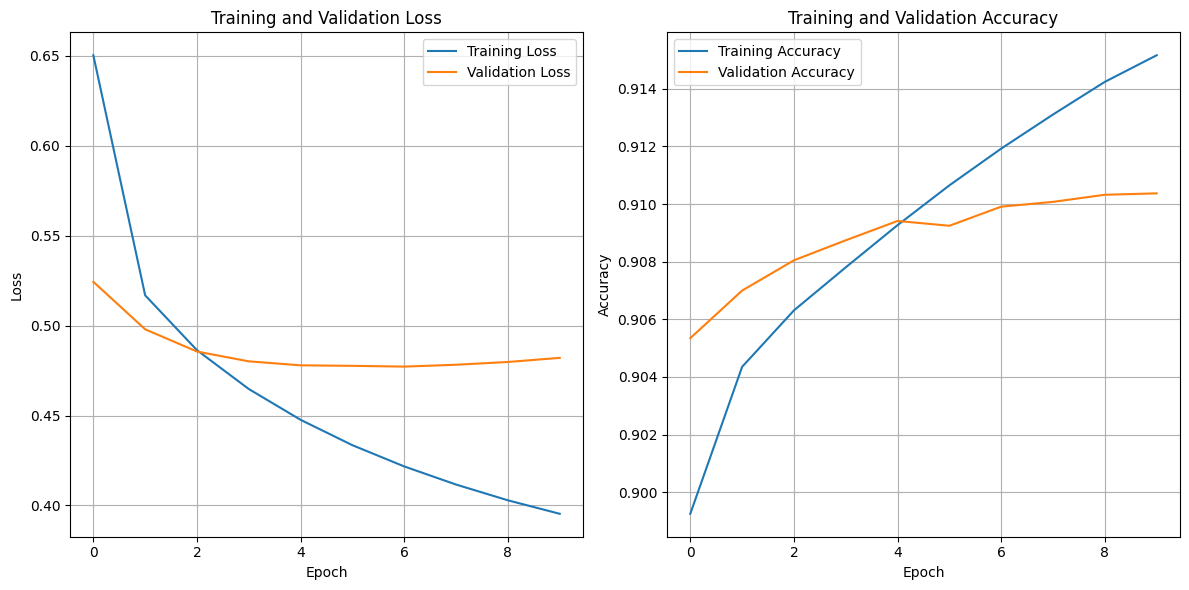


📈 Graficando historial para la configuración: {'num_heads': 4, 'ff_dim': 128}


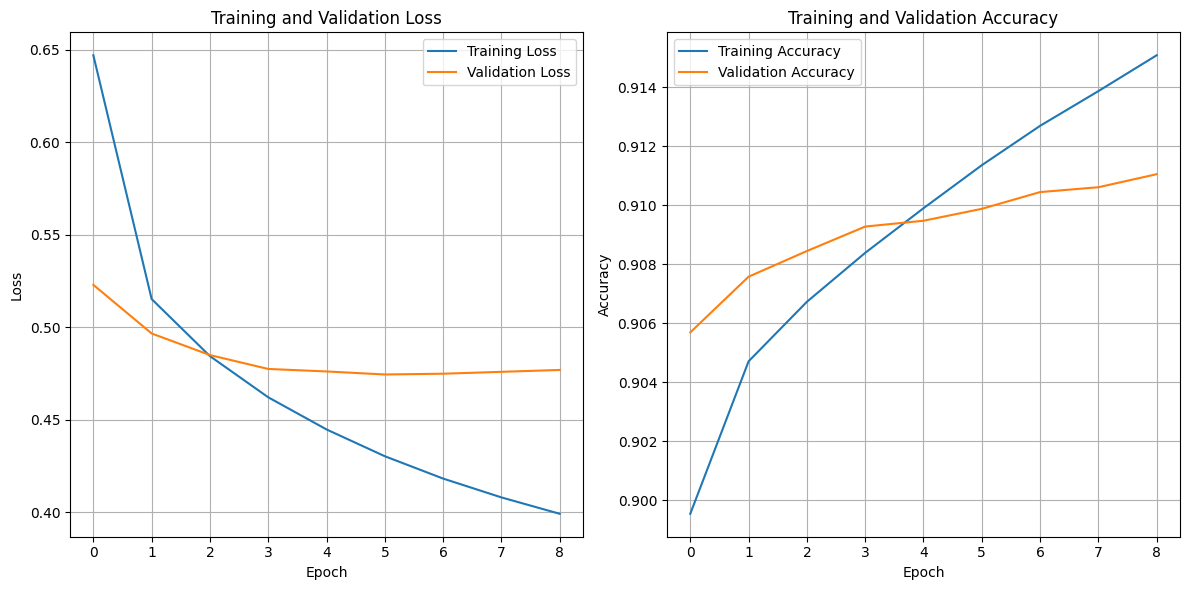


📈 Graficando historial para la configuración: {'num_heads': 8, 'ff_dim': 512}


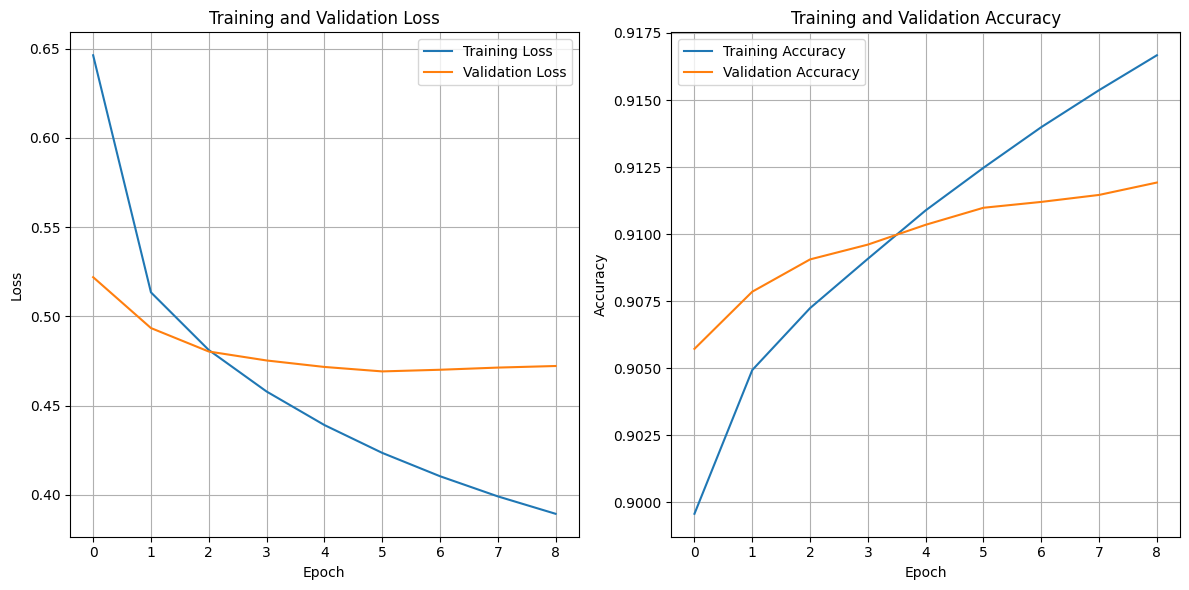

In [ ]:
# prompt: graficar las perdidas que estan en el history

def plot_training_history(history):
    """
    Grafica las pérdidas y la precisión durante el entrenamiento y validación.

    Args:
        history: Objeto History devuelto por model.fit().
    """
    plt.figure(figsize=(12, 6))

    # Graficar Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Graficar Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Llama a la función para cada historia de entrenamiento
for i, history in enumerate(histories):
    print(f"\n📈 Graficando historial para la configuración: {experiments[i]}")
    plot_training_history(history)


#### Valor promedio en 100 muestras de BLEU

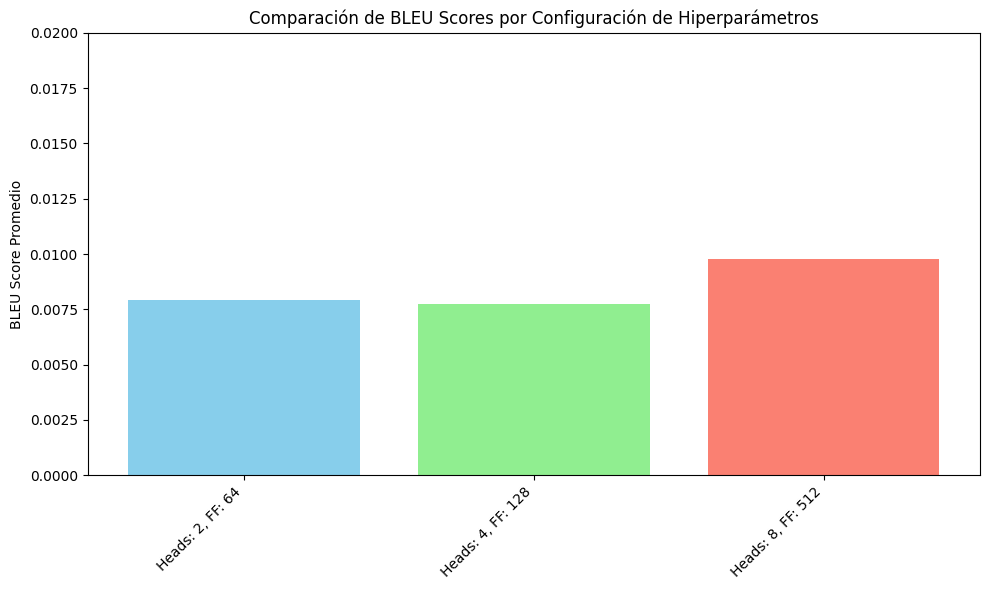

In [ ]:
def plot_bleu_scores(results, experiments):
    bleu_scores = [result[0] for result in results]
    labels = [f"Heads: {config['num_heads']}, FF: {config['ff_dim']}" for config in experiments]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, bleu_scores, color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylabel('BLEU Score Promedio')
    plt.title('Comparación de BLEU Scores por Configuración de Hiperparámetros')
    plt.ylim(0, 0.02)  # Ajusta el límite Y si es necesario para mejor visualización
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_bleu_scores(results, experiments)

#### Rouge-1 y Rouge-L

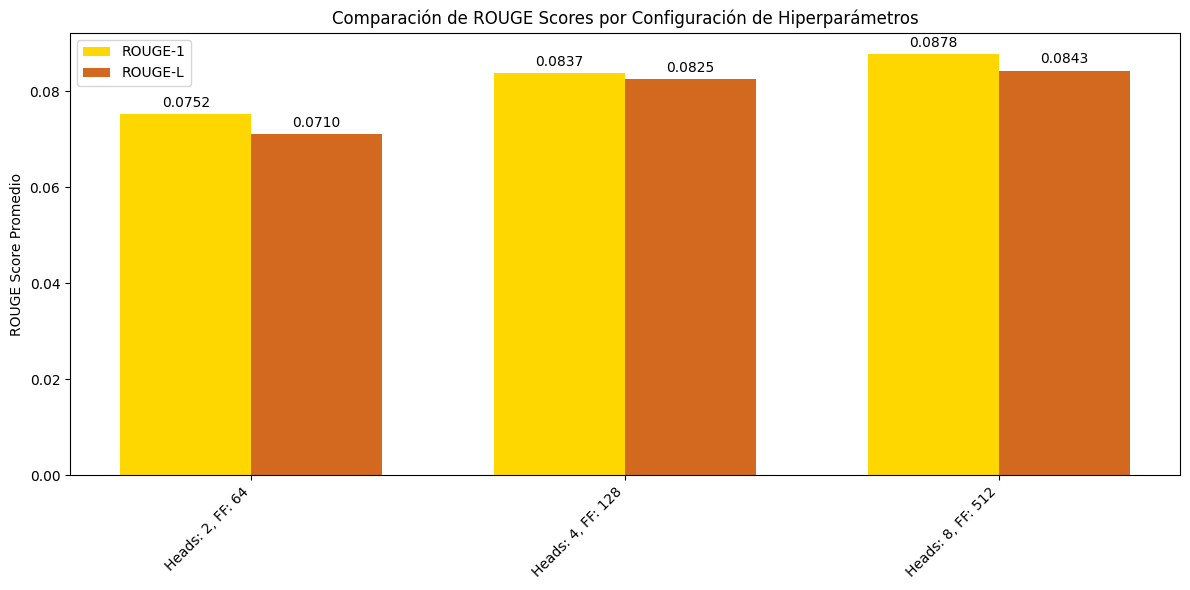

In [ ]:
def plot_rouge_scores(results, experiments):
    rouge1_scores = [result[1] for result in results]
    rougeL_scores = [result[2] for result in results]
    labels = [f"Heads: {config['num_heads']}, FF: {config['ff_dim']}" for config in experiments]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, rouge1_scores, width, label='ROUGE-1', color='gold')
    rects2 = ax.bar(x + width/2, rougeL_scores, width, label='ROUGE-L', color='chocolate')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('ROUGE Score Promedio')
    ax.set_title('Comparación de ROUGE Scores por Configuración de Hiperparámetros')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

plot_rouge_scores(results, experiments)

## 6. Presentación de Resultados y Conclusiones

En esta sección, resumiremos los resultados obtenidos, mostrando cómo los ajustes de los hiperparámetros impactaron en el rendimiento del modelo.
- **Resultados Finales**:

  - Modelo 1:
    - Configuración: [2 heads attention + feedforward dimension 64]
    - Resultados:
                  BLEU promedio en 100 muestras: 0.0079
                  ROUGE-1 promedio: 0.0752
                  ROUGE-L promedio: 0.0710
  - Modelo 2:
    - Configuración: [4 heads attention + feedforward dimension 128]
    - Resultados:  
                  BLEU promedio en 100 muestras: 0.0077
                  ROUGE-1 promedio: 0.0837
                  ROUGE-L promedio: 0.0825
  - Modelo 3:
    - Configuración: [8 heads attention + feedforward dimension 512]
    - Resultados:  
                  BLEU promedio en 100 muestras: 0.0098
                  ROUGE-1 promedio: 0.0878
                  ROUGE-L promedio: 0.0843

    Observamos que a mayor cantidad de cabezales de atencion el modelo se entrena de mejor manera y como resultado tiende a responder de manera mas coherente. La metrica que tiene mas relevancia en nustro casod e estudio es la de rouge-1 o L ya que Bleu lo que mide es la precision de las respuestas que en nuestro caso no es muy relevante. Por el contrario Rouge mide la capacidad del modelo de aprender a generar respuestas con los conceptos clave de las oraciones de referencia. Esto quiere decir que puede generar contenido nuevo pero siempre conservando las ideas clave de la referencia.

    Entre rouge-L y rouge-1 la diferencia esta enq ue Rouge-L mide tambien el orden de las ideas que se generan. Mientras que Rouge-1 compara palabra a palabra y busca coincidencias entre lo generado y lo referenciado.
    
    ↓

- **Conclusiones**: Luego de entrenar estos modelos, aprendimos a modelar e identificar los distintos modulos o componentes dentro de un transformer. Codigicar y decodificar son los pasos clave y que hacen la diferencia en estos modelos de deep learning, permitiendonos entregar una sequiencia de palabras y obteniendo una sequencia de respuesta.

La calidad de las respuestas generadas (secuencias de salida), se puede medir con las metricas BLEU o ROUGE, utilizadas tambien en este estudio, las cuales mostraron resultados no muy favorables, a pesar que las respuestas generadas tienen algun grado de coherencia.

¡Gracias por revisar nuestro proyecto! Esperamos que esta implementación demuestre nuestro dominio en el uso de transformers para NLP.
